# พลอตข้อมูลภาพสีอินฟราเรดของอุณหภูมิยอดเมฆ GOES13

* โค้ดได้มาจาก MetPy Monday ลิงก์น้ https://www.youtube.com/watch?v=si_kx1dI-FA&list=PLQut5OXpV-0ir4IdllSt1iEZKTwFBa7kO&index=44

* จะใช้ ctables ที่ชื่อ ir_drgb จากลิงก์ MetPy https://unidata.github.io/MetPy/latest/api/generated/metpy.plots.ctables.html เพื่อพลอตภาพสีอุณหภูมิยอดเมฆจากข้อมูลอินฟราเรด

### แหล่งเรียนรู้ดาวเทียมอุตุนิยมวิทยา
* Dr.Kevin Perry จากมหาวิทยาลัยยูท่าห์ สอนเรื่องดาวเทียมอุตุนิยมวิทยา ดีมาก https://www.youtube.com/watch?v=WK0NyUdnsqQ

In [5]:
# นำเข้าไลบราลี่
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.pyplot as plt
from netCDF4 import Dataset, num2date
import numpy as np

In [6]:
# ตัวแปรไฟล์ชาแนล 4 คือ อินฟราเรดของ GOES13
file_ir ='goes13.2011.117.200229.BAND_04.nc'

In [7]:
#อ่านข้อมูลอินฟราเรดมาเก็บในตัวแปร
ds_ir = Dataset(file_ir, 'r')

In [8]:
#แปลงข้อมูลจาก 16 บิทไปเป็น 10 บิท
ir_10bit = ds_ir.variables['data'][0]/32 

In [9]:
#มีความแตกต่างของ resolution ระหว่าง visible กับ infrared 
# mask ค่าสูงของ infrared
lat_ir = np.ma.masked_values(ds_ir.variables['lat'][:], 2.14329e+09) # 2.14329e+09 เป็นค่าพิกัดสูงสุดที่เกินจริงที่ต้อง mask ไว้ว่าจะไม่เอาใช้ 
lon_ir = np.ma.masked_values(ds_ir.variables['lon'][:], 2.14329e+09)

In [10]:
# ทำการ mask
ir_masked = np.ma.masked_array(ir_10bit, mask=lat_ir.mask)

## แปลงค่า RAW count ไปเป็น Bightness temperature
* ต้องแปลงค่า Raw count ไปเป็นค่า brightness temperature สำหรับข้อมูลแบนด์อินฟราเรด
* เข้าไปที่ https://www.ospo.noaa.gov/Operations/GOES/calibration/index.html แล้วเลือกLearn how to convert GVAR counts to temperature in the infrared channels!  จะไปที่ลิงก์ https://www.ospo.noaa.gov/Operations/GOES/calibration/gvar-conversion.html อธิกระบวนการสองขั้นด้วยกันคือ 
    * Conversion of Imager GVAR Count to Scene Radiance สมการ R=(X-b)/m ดูตาราง 1-2 ใน channel ที่ 4 เพื่อใช้ค่า m และ b ลิงก์ https://www.ospo.noaa.gov/Operations/GOES/calibration/gvar-conversion.html#scene
    * Conversion of Imager GVAR Count to Temperature สมการ Teff ลิงก์ https://www.ospo.noaa.gov/Operations/GOES/calibration/gvar-conversion.html#temp

In [11]:
# ค่า m และ b จากตาราง 1-2
m_ir = 5.2285
b_ir =15.6854

#คำนวนค่า R นั่นคือค่า Radiance
R_ir = (ir_masked - b_ir)/m_ir

In [12]:
# คำนวนค่า Teff 

#กำหนดค่า inverse pluck function constants
c1 = 1.191066e-5
c2 = 1.438833

In [13]:
# ใช้ค่าจากตาราง 2-6 GOES-13 สำหรับแบนด์ 4 เพื่อใช้ค่า v กับ alfa และ beta
v_ir = 937.23

u_ir = -0.386043 #alfa

bt_ir = 1.001298 #beta

In [14]:
# คำนวนค่า Teff 
T_eff_ir = (c2*v_ir)/(np.log(1+(c1*v_ir**3)/R_ir)) # invalid value encountered in log เกิดจาก missing value ไม่มีปัญหา

C:\Users\Admin\anaconda3\envs\metpy\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in log
  


In [15]:
# คำนวณหาค่าอุณหภูมิส่องสว่างจากแบนด์อินฟราเรด Brightness Temperature
BT_ir = u_ir + bt_ir * T_eff_ir
BT_ir.max() #ตรวจสอบ Brightness Temperature ของพื้นผิว

331.24628

## พลอตภาพอินฟราเรดสี

In [16]:
from metpy.plots import ctables

ir_cmap = ctables.registry.get_colortable('ir_drgb_r') #_r คือการรีเวิร์ส color table
ir_cmap.set_under('k') # หากข้อมูลมีค่าที่ต่ำมากๆ จะกำหนดจะให้เป็นสีดำ

In [17]:
import numpy as np
# พลอตแผนที่ค่า Brightness Temperature
vtime = num2date(ds_ir.variables['time'][:], units=ds_ir.variables['time'].units) #เซตค่าตัวแปรเวลา

mapcrs = ccrs.Geostationary(central_longitude=-75)

# หาค่า max min index ที่อยู่ในรูปของพิกัดภูมิศาสตร์ แล้วจะทำการแปลงไปเป็นระบบพิกัด Geostationary
ilon_min = np.unravel_index(np.argmin(lon_ir), lon_ir.shape) #หาอินเด็กซ์ของลองจิจูดที่ต่ำสุด แล้วทำให้ shape ของอาเรย์เท่าเดิมคือ 2D
ilon_max = np.unravel_index(np.argmax(lon_ir), lon_ir.shape) #หาอินเด็กซ์ของลองจิจูดที่ต่ำสุด แล้วทำให้ shape ของอาเรย์เท่าเดิมคือ 2D

ilat_min = np.unravel_index(np.argmin(lat_ir), lat_ir.shape) #หาอินเด็กซ์ของละติจูดที่ต่ำสุด แล้วทำให้ shape ของอาเรย์เท่าเดิมคือ 2D
ilat_max = np.unravel_index(np.argmax(lat_ir), lat_ir.shape) #หาอินเด็กซ์ของละติจูดที่ต่ำสุด แล้วทำให้ shape ของอาเรย์เท่าเดิมคือ 2D

#แปลงไปเป็นระบบพิกัด Geostationary
LONpt0 = mapcrs.transform_point(lon_ir[ilon_min],lat_ir[ilon_min], ccrs.Geodetic() )[0]
LONpt1 = mapcrs.transform_point(lon_ir[ilon_max],lat_ir[ilon_max], ccrs.Geodetic() )[0]

LATpt0 = mapcrs.transform_point(lon_ir[ilat_min],lat_ir[ilat_min], ccrs.Geodetic() )[1]
LATpt1 = mapcrs.transform_point(lon_ir[ilat_max],lat_ir[ilat_max], ccrs.Geodetic() )[1]

C:\Users\Admin\anaconda3\envs\metpy\lib\site-packages\cartopy\crs.py:825: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(multi_line_string) > 1:
C:\Users\Admin\anaconda3\envs\metpy\lib\site-packages\cartopy\crs.py:877: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for line in multi_line_string:
C:\Users\Admin\anaconda3\envs\metpy\lib\site-packages\cartopy\crs.py:944: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(p_mline) > 0:


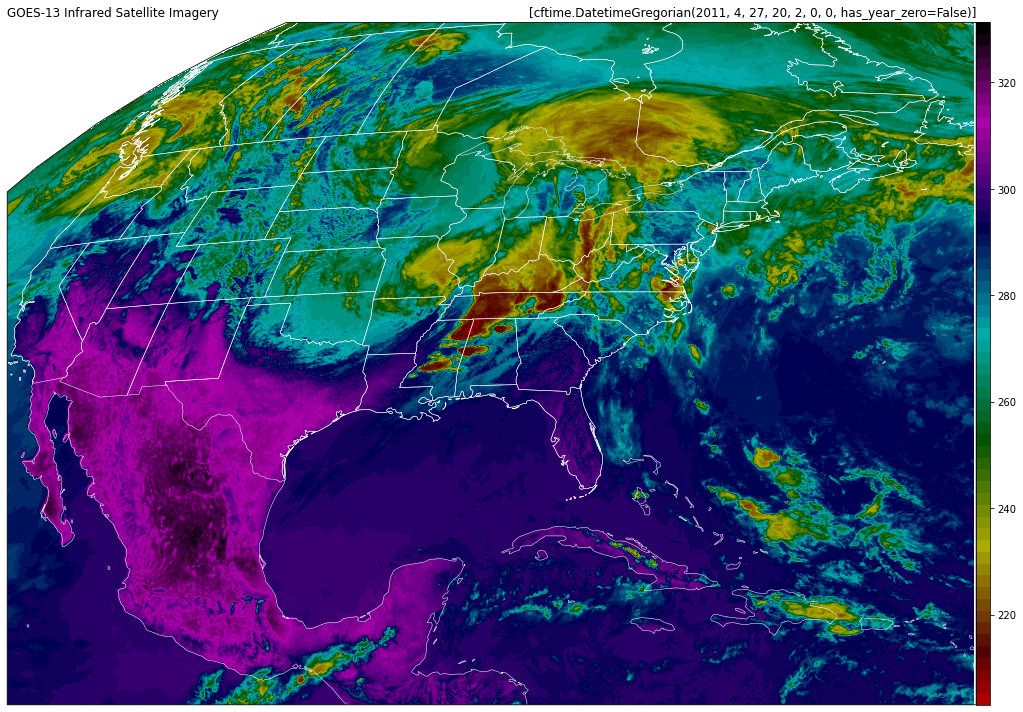

In [20]:
fig = plt.figure(1, figsize=(19,10))
ax = plt.subplot(111, projection=mapcrs)

img = ax.imshow(BT_ir, cmap=ir_cmap, origin='upper',   #ir_cmap
                extent=(LONpt0, LONpt1, LATpt0, LATpt1)) 

plt.colorbar(img, orientation = 'vertical', pad=0, aspect=50) # ตรงนี้เพิ่ม color bar ลงในภาพด้านข้าง

ax.add_feature(cfeature.COASTLINE.with_scale('50m'), edgecolor='white', linewidth = 0.5)
ax.add_feature(cfeature.STATES.with_scale('50m'), edgecolor='white', linewidth = 0.5)

plt.title(vtime, loc='right')
plt.title('GOES-13 Infrared Satellite Imagery', loc='left')

plt.tight_layout()
plt.show()

* ภาพสีของอุณหภูมิส่องสว่างที่ได้จากแบนด์ออินฟราเรด ทำให้เข้าใจสภาพบรรยากาศได้ดียิ่งขึ้น
* ตรงแผ่นดินประเทศเม็กซิโก และทางรัฐเท็กซัส นิวเม็กซิโก อริโซนา เนวาดา แคลิฟอร์เนีย พบว่ามีค่าอุณณหภูมิพื้นผิวที่ได้จากอินฟราเรดที่สูงถึง 320 เคลวินในช่วงเวลากลางวัน ซึ่งเป็นพื้นที่ภูเขาสูง
* ในขณะที่ทางด้านตะวันออกของสหรัฐอเมริกาและแคนาดา พบว่ามีกลุ่มเมฆฝนที่มีค่าอุณหภูมิที่ต่ำมาก
* สามารถนำภาพไอน้ำมาพลอตเป็นภาพสีได้ด้วย


# พลอตภาพไอน้ำ water vapor แบบสี

In [24]:
# นำเข้าไลบราลี่
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.pyplot as plt
from netCDF4 import Dataset, num2date
import numpy as np

In [25]:
file_wv = 'goes13.2011.117.200229.BAND_03.nc' # แบนด์ 3 water vapor

In [26]:
# เปิดข้อมูลไอน้ำมาเก็บไว้
ds_wv = Dataset(file_wv, 'r')

In [27]:
# แปลงข้อมูล 16 บิท เป็น 10 บิท
wv_10bit = ds_wv.variables['data'][0]/32

In [28]:
# mask ค่าพิกัดสูงของ water vapor
lat_wv = np.ma.masked_values(ds_wv.variables['lat'][:], 2.14329e+09) # 2.14329e+09 เป็นค่าพิกัดสูงสุดที่เกินจริงที่ต้อง mask ไว้ว่าจะไม่เอาใช้ 
lon_wv = np.ma.masked_values(ds_wv.variables['lon'][:], 2.14329e+09)

In [29]:
# apply masked 
wv_masked = np.ma.masked_array(wv_10bit, mask=lat_wv.mask)

## แปลงค่า Raw count เป็นค่า Water vapor ใช้หลักการเดียวกันกับอินฟราเรดในการหา Brightness Temperature

In [30]:
# ค่า m และ b จากตาราง 1-2  ใช้ channel 3 จากลิงก์ https://www.ospo.noaa.gov/Operations/GOES/calibration/gvar-conversion.html#scene
m_wv = 38.8383
b_wv =29.1287

#คำนวนค่า R นั่นคือค่า Radiance
R_wv = (wv_masked - b_wv)/m_wv

In [31]:
#กำหนดค่า inverse pluck function constants
c1 = 1.191066e-5
c2 = 1.438833

In [32]:
# ใช้ค่าจากตาราง 2-6 GOES-13 สำหรับแบนด์ 3 เพื่อใช้ค่า v กับ alfa และ beta จากลิงก์ https://www.ospo.noaa.gov/Operations/GOES/calibration/gvar-conversion.html#scene
v_wv = 1521.66

u_wv = -3.607841 #alfa

bt_wv = 1.010010 #beta

In [33]:
# คำนวนค่า Teff 
T_eff_wv = (c2*v_wv)/(np.log(1+(c1*v_wv**3)/R_wv)) # invalid value encountered in log เกิดจาก missing value ไม่มีปัญหา

C:\Users\Admin\anaconda3\envs\metpy\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in log
  


In [34]:
# คำนวณหาค่าไอน้ำจากแบนด์ 3
BT_wv = u_wv + bt_wv * T_eff_wv
BT_wv.max() #ตรวจสอบค่าไอน้ำ

260.76617

## พลอตแผนที่สีของปริมาณไอน้ำในอากาศ GOES13 แบนด์ 3

In [35]:
# ใช้ค่า color table  ที่ชื่อ ''WVCIMSS' จากhttps://unidata.github.io/MetPy/latest/api/generated/metpy.plots.ctables.html
from metpy.plots import ctables

wv_cmap = ctables.registry.get_colortable('WVCIMSS_r') #_r คือการรีเวิร์ส color table
wv_cmap.set_under('k') # หากข้อมูลมีค่าที่ต่ำมากๆ จะกำหนดจะให้เป็นสีดำ

In [36]:
## พลอตแผนที่ไอน้ำในอากาศ GOES13 แบนด์ 3
import numpy as np
# พลอตแผนที่ค่าไอน้ำในอากาศ
vtime = num2date(ds_wv.variables['time'][:], units=ds_wv.variables['time'].units) #เซตค่าตัวแปรเวลา

mapcrs = ccrs.Geostationary(central_longitude=-75)

# หาค่า max min index ที่อยู่ในรูปของพิกัดภูมิศาสตร์ แล้วจะทำการแปลงไปเป็นระบบพิกัด Geostationary
ilon_min = np.unravel_index(np.argmin(lon_wv), lon_wv.shape) #หาอินเด็กซ์ของลองจิจูดที่ต่ำสุด แล้วทำให้ shape ของอาเรย์เท่าเดิมคือ 2D
ilon_max = np.unravel_index(np.argmax(lon_wv), lon_wv.shape) #หาอินเด็กซ์ของลองจิจูดที่ต่ำสุด แล้วทำให้ shape ของอาเรย์เท่าเดิมคือ 2D

ilat_min = np.unravel_index(np.argmin(lat_wv), lat_wv.shape) #หาอินเด็กซ์ของละติจูดที่ต่ำสุด แล้วทำให้ shape ของอาเรย์เท่าเดิมคือ 2D
ilat_max = np.unravel_index(np.argmax(lat_wv), lat_wv.shape) #หาอินเด็กซ์ของละติจูดที่ต่ำสุด แล้วทำให้ shape ของอาเรย์เท่าเดิมคือ 2D

#แปลงไปเป็นระบบพิกัด Geostationary
LONpt0 = mapcrs.transform_point(lon_wv[ilon_min],lat_wv[ilon_min], ccrs.Geodetic() )[0]
LONpt1 = mapcrs.transform_point(lon_wv[ilon_max],lat_wv[ilon_max], ccrs.Geodetic() )[0]

LATpt0 = mapcrs.transform_point(lon_wv[ilat_min],lat_wv[ilat_min], ccrs.Geodetic() )[1]
LATpt1 = mapcrs.transform_point(lon_wv[ilat_max],lat_wv[ilat_max], ccrs.Geodetic() )[1]

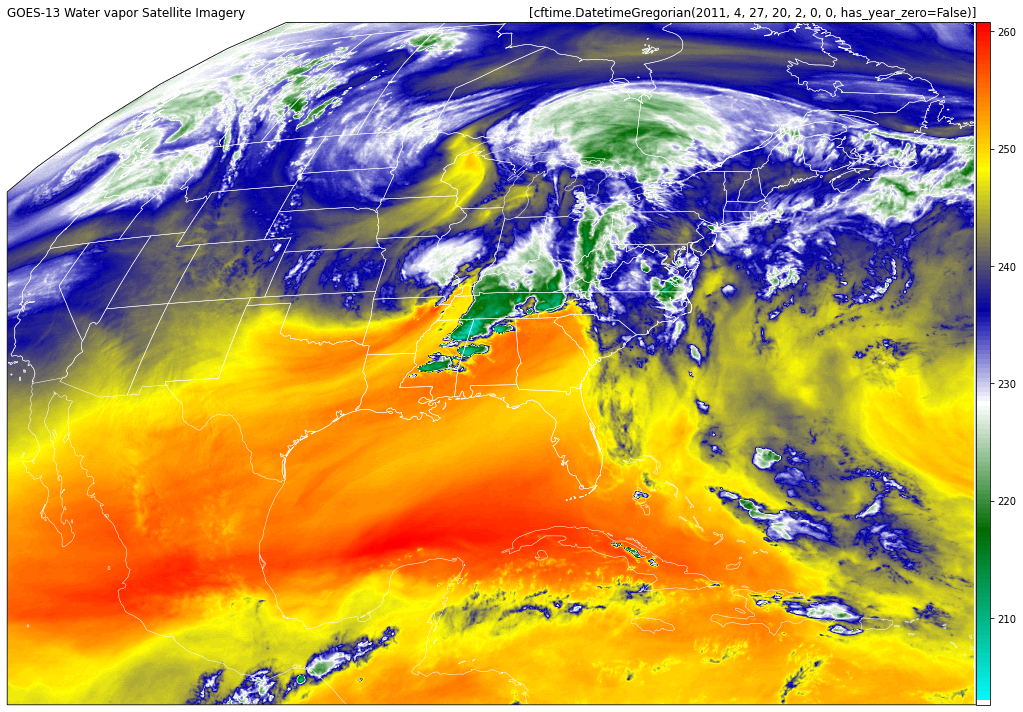

In [37]:
fig = plt.figure(1, figsize=(19,10))
ax = plt.subplot(111, projection=mapcrs)

img = ax.imshow(BT_wv, cmap=wv_cmap, origin='upper',   #BT_wv และเปลี่ยนเป็น Greys
                extent=(LONpt0, LONpt1, LATpt0, LATpt1)) 

plt.colorbar(img, orientation = 'vertical', pad=0, aspect=50) # ตรงนี้เพิ่ม color bar ลงในภาพด้านข้าง

ax.add_feature(cfeature.COASTLINE.with_scale('50m'), edgecolor='white', linewidth = 0.5)
ax.add_feature(cfeature.STATES.with_scale('50m'), edgecolor='white', linewidth = 0.5)

plt.title(vtime, loc='right')
plt.title('GOES-13 Water vapor Satellite Imagery', loc='left')

plt.tight_layout()
plt.show()

* ภาพที่ได้นี้ทำให้เห็นสภาพ moist กับ dry air ได้เป็นอย่างดีกว่าภาพสีเทา โดยในทางอ่าวเม็กซิโกและแผ่นดินเม็กซิโก แสดงถึงสภาพ dry ที่มีไอน้ำในอากาศที่น้อย แสดงเป็นสีแดงและเหลือง แสดงเป็นค่าอุณฆภูมิส่องสว่างที่สูงเกือบ 260 เคลวิน ในขณะที่่พื้นที่ทางตะวันออกของอเมริกาและแคนนาดา มีความชื้นที่มากกว่า แสดงด้วยค่าอุณหภูมิที่ต่ำ เป็นสีน้ำเงิน
* อย่างไรก็ตามภาพนี้ยังปรับปรุงได้อีก ด้วยการปรับค่าแบบ normalization เพื่อให้เมื่อมีการนำภาพในช่วงเวลาอื่นมาใช้จะได้มีค่าสีจาก color bar ที่อยู่ใน range หรือช่วงค่าสีเดียวกัน 


## พลอตค่า color table แบบ range เพื่อให้มีช่วงค่าสีเดียวกัน กรณีที่ต้องการเปรียบเทียบหลายช่วงเวลา

In [40]:
# ใช้ค่า color table  ที่ชื่อ ''WVCIMSS' จากhttps://unidata.github.io/MetPy/latest/api/generated/metpy.plots.ctables.html
from metpy.plots import ctables

wv_norm, wv_cmap = ctables.registry.get_with_range('WVCIMSS_r', 190, 273) #แก้เป็น .get_with_range
wv_cmap.set_under('k') # หากข้อมูลมีค่าที่ต่ำมากๆ จะกำหนดจะให้เป็นสีดำ

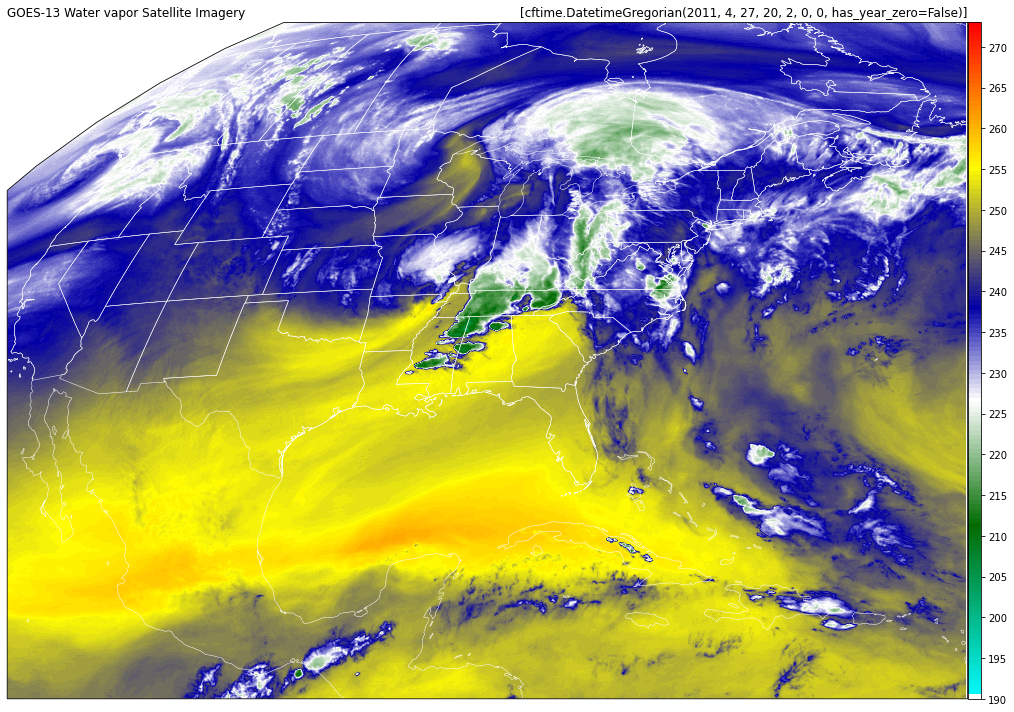

In [42]:
fig = plt.figure(1, figsize=(19,10))
ax = plt.subplot(111, projection=mapcrs)

img = ax.imshow(BT_wv, cmap=wv_cmap, norm= wv_norm, origin='upper',   #เพิ่ม norm= wv_norm
                extent=(LONpt0, LONpt1, LATpt0, LATpt1)) 

plt.colorbar(img, orientation = 'vertical', pad=0, aspect=50, ticks=range(190, 280,5)) # ตรงนี้เพิ่ม ticks=range(190, 280,5)

ax.add_feature(cfeature.COASTLINE.with_scale('50m'), edgecolor='white', linewidth = 0.5)
ax.add_feature(cfeature.STATES.with_scale('50m'), edgecolor='white', linewidth = 0.5)

plt.title(vtime, loc='right')
plt.title('GOES-13 Water vapor Satellite Imagery', loc='left')

plt.tight_layout()
plt.show()

* ภาพไอน้ำในอากาศแสดงถึงการกระจายตัวของไอน้ำในระดับบรรยากาศชั้นกลาง ไปจนระดับสูงของชั้นบรรยากาศโทรโพสเฟียร์
* บริเวณที่มีพื้นที่สีเขียวและมีสีขาวอยู่รอบๆ แสดงถึงพื้นที่ที่มีความหนาของเมฆอยู่ ในขณะที่สีน้ำเงินแสดงถึงบริเวณที่มีไอน้ำที่มากในระดับบรรยากาศที่ต่ำลงไป ในขณะที่สีเหลืองและสีแดงแสดงถึงบริเวณที่มีความแห้งแล้งหรือบริเวณที่มีไอน้ำน้อย
* ทำให้เห็นว่าในมลรัฐ Mississippi กับ Alabama มี severe storm เกิดขึ้น เนื่องจาก มีอากาศที่แห้งที่แสดงในแผนที่เป็นสีเหลือง กับบริเวณที่มีเมฆหนาหรือ thick cloud ที่แสดงเป็นสีเขียวและขาว ซึ่งวิเคราะห์ได้ง่ายกว่าการใช้ภาพสีเทาอย่างเดียว
* อ่านวิธีการแปลผลภาพไอน้ำในอากาศเพิ่มเติมได้จาก
    * https://cimss.ssec.wisc.edu/satellite-blog/archives/3
    * https://cimss.ssec.wisc.edu/satellite-blog/archives/14745


## แนะนำให้เรียนเรื่องเส้นโครงแผนที่ในการพลอตภาพ GOES16 https://www.youtube.com/watch?v=7YH-M7MSRF4&list=PLQut5OXpV-0ir4IdllSt1iEZKTwFBa7kO&index=45

### งานมอบหมายนิสิต
* ให้นิสิตดาวน์โหลดข้อมูลวันที่ 26 และ 28 สิงหาคม 2011 ของข้อมูล GOES13 ซึ่งเป็นช่วงที่พายุเฮอริเคน Irene พัดเข้ามาในพื้นที่ทางตะวันออกของประเทศสหรัฐอเมริกา อ่านจากลิงก์นี้ https://en.wikipedia.org/wiki/Hurricane_Irene
* ให้นิสิตทำการพลอตข้อมูลอุณหภูมิส่องสว่างและไอน้ำในอากาศแบบภาพสี โดยใช้โค้ดด้านบน
* ให้นิสิตบรรยายผลที่ได้จากภาพดาวเที่ยม โดยเปรียบเทียบระหว่างข้อมูลสองวันดังกล่าว 